# Figure 3: Model of the growth dynamics in the absence of treatment

In [4]:
import sys
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from tqdm import tqdm
from lmfit import minimize, Parameters
from itertools import product

# Import my own libraries
sys.path.append('./utils/')
import myUtils as utils
from odeModels import MakeModelFromStr
from fittingUtils import residual, ComputeRSquared, PlotFit, PlotData, LoadFit

# Format plot
sns.set(style="white",
        rc={'figure.figsize':(12,6), 'xtick.labelsize': 22, 'ytick.labelsize': 22})

In [5]:
# Data and solver configurations
modelList = ["Exponential", "Logistic", "Gompertz", "vonBertalanffy", "GeneralisedLogistic"]
runFitting = True
solver_kws={'method':'DOP853', 'absErr':1.0e-8, 'relErr':1.0e-6, 'suppressOutputB':False}

# Parameters to fit
params = Parameters()
params.add('r', value=0.05, min=1e-4, max=2., vary=True)
params.add('v', value=1, min=0, max=5, vary=True)
params.add('K', value=100., min=0, max=100., vary=True)
params.add('N0', value=10, min=0, max=100., vary=False)
params.add('DMax', value=100, vary=False)
optimiser_kws = {'method':'least_squares', 'xtol':1e-8, 'ftol':1e-8,
                 'nan_policy':'omit', 'verbose':0}

# Environment
dataDir = "./data/"
modelDir = "./fits/growthModel/"
modelPalette = {"Exponential":sns.xkcd_rgb["grey"], "Logistic":sns.xkcd_rgb["clear blue"], 
                "Gompertz":sns.xkcd_rgb["merlot"], "vonBertalanffy":sns.xkcd_rgb["topaz"],
                "GeneralisedLogistic":sns.xkcd_rgb["mango"]}

In [6]:
# Load off-treatment data
dataDf_all = pd.read_csv("./data/continuousTreatmentDf_cleaned.csv",index_col=0)
dataDf_all = dataDf_all[(dataDf_all.DrugConcentration==0)]

## b) Fit and compare growth models using data from cells grown in untreated conditions

### Carry out fitting

In [7]:
for cellLine in ["OVCAR3","OVCAR4"]:
    # Prepare data
    trainingData = dataDf_all[(dataDf_all.CellLine==cellLine) & (dataDf_all.SeedingDensity=="lowDensity")]
    trainingData = trainingData.groupby(by="Time").mean()
    trainingData.reset_index(inplace=True)

    for modelName in tqdm(modelList):
        # Setup env
        currOutDir = os.path.join(modelDir,cellLine,modelName)
        utils.mkdir(currOutDir)
        tmpModel = MakeModelFromStr(modelName)
        currParams = Parameters()
        currParams.add_many(*[params[x] for x in tmpModel.paramDic.keys()])
        if params['N0'].vary==False: params['N0'].value = trainingData.Confluence.iloc[0]

        # Fit
        fitObj = minimize(residual, currParams, args=(0, trainingData, tmpModel, "Confluence", solver_kws),**optimiser_kws)
        fitObj.modelName = modelName
        fitObj.rSq = ComputeRSquared(fitObj,trainingData)

        # Post-process
        pickle.dump(obj=fitObj, file=open(os.path.join(currOutDir,"fitObj_fit_%d.p"%(fitId)), "wb"))

100%|██████████| 5/5 [00:00<00:00,  8.99it/s]


### Plot fits

100%|██████████| 5/5 [00:00<00:00, 99.25it/s]


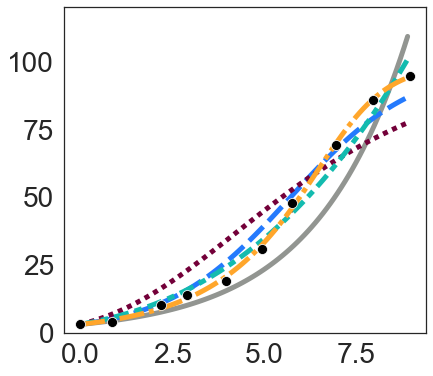

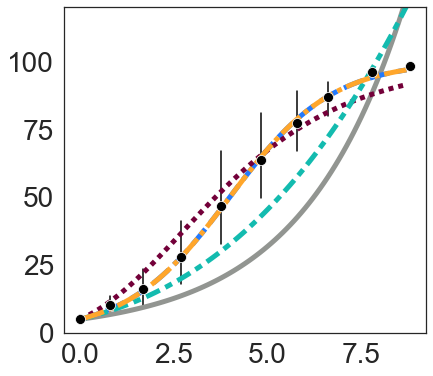

In [8]:
for cellLine in ["OVCAR3","OVCAR4"]:
    outDir = os.path.join(modelDir,cellLine)
    currData = dataDf_all[(dataDf_all.CellLine==cellLine) & (dataDf_all.SeedingDensity=="lowDensity")]
    # Load models and simulate
    tmpList = []
    for modelName in tqdm(modelList):
        _,myModel = LoadFit(modelName,fitDir=os.path.join(outDir,modelName))
        myModel.Simulate(treatmentScheduleList=utils.ExtractTreatmentFromDf(currData),**solver_kws)
        myModel.Trim(dt=.1) # Interpolate solution to a regular grid, as ODE solver uses an adaptive soluation method
        myModel.resultsDf['Model'] = modelName
        tmpList.append(myModel.resultsDf.copy())
    modelFitsDf = pd.concat(tmpList)
    
    # Plot
    fig, ax = plt.subplots(1,1,figsize=(6.5,6))
    sns.lineplot(x="Time",y="TumourSize", hue="Model", style="Model",
                 lw=5,palette=modelPalette,
                 legend=False,
                 data=modelFitsDf, ax=ax)
    sns.lineplot(x="Time",y="Confluence",style="CellLine",err_style='bars', #units="ReplicateId", estimator=None,
             markers="o", lw=0, markersize=10, color="black",
             legend=False,
            data=currData,ax=ax)
    ax.tick_params(labelsize=28)
    ax.set_ylim(0,120)
    ax.set_xlabel("")
    ax.set_ylabel("")
    plt.savefig("./figures/fits_growthModel_%s.pdf"%cellLine)

### Quantify goodness-of-fit using AIC

100%|██████████| 5/5 [00:00<00:00, 1053.05it/s]


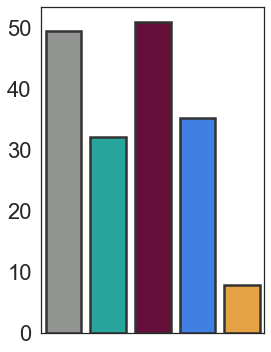

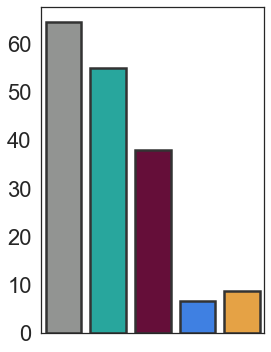

In [9]:
measure = "AIC"

for cellLine in ["OVCAR3","OVCAR4"]:
    outDir = os.path.join(modelDir,cellLine)
    tmpList = []
    for modelName in tqdm(modelList):
        fitObj,_ = LoadFit(modelName,fitDir=os.path.join(outDir,modelName))
        tmpList.append({"Model":modelName, "FitId":fitObj.fitId,
                        "r2":fitObj.rSq, "AIC":fitObj.aic, "BIC":fitObj.bic})
    comparisonDf_gof = pd.DataFrame(tmpList)
    
    # Plot
    fig, ax = plt.subplots(1,1,figsize=(4,6))
    comparisonDf_gof.sort_values(by=measure,inplace=True)
    sns.barplot(x="Model",y=measure,
                edgecolor=".2",linewidth=2.5,
                palette=modelPalette,
                order=["Exponential", "vonBertalanffy", "Gompertz", "Logistic", "GeneralisedLogistic"],
                data=comparisonDf_gof, ax=ax)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticks([])
    plt.savefig("./figures/%s_fit_%s.pdf"%(measure,cellLine))

## c) Test model by benchmarking its ability to predict growth from higher initial seeding density

### Generate predictions

In [10]:
# Run predictions
tmpList = []
tmp2List = []
for cellLine in ["OVCAR3","OVCAR4"]:
    outDir = os.path.join(modelDir,cellLine)
    testingData = dataDf_all[(dataDf_all.CellLine==cellLine) & (dataDf_all.SeedingDensity=="highDensity")]
    # Load models and simulate
    for replicateId,modelName in product(range(1,4),modelList):
        fitObj,myModel = LoadFit(modelName,fitDir=os.path.join(outDir,modelName))
        currTestingData = testingData[testingData.ReplicateId==replicateId]

        # Simulate
        myModel.SetParams(N0=currTestingData.Confluence.iloc[0])
        myModel.Simulate(treatmentScheduleList=utils.ExtractTreatmentFromDf(testingData),**solver_kws)
        myModel.Trim(dt=.1)
        myModel.resultsDf['Model'] = modelName
        myModel.resultsDf['ReplicateId'] = replicateId
        myModel.resultsDf['CellLine'] = cellLine
        tmpList.append(myModel.resultsDf.copy())

        # Compute r2 of prediction
        fitObj.params['N0'].value = currTestingData.Confluence.iloc[0]
        fitObj.residual = residual(data=currTestingData,
                                   model=myModel,params=fitObj.params,
                                   x=None,feature="Confluence")
        tmp2List.append({"CellLine":cellLine, "Model":modelName, 
                         "FitId":fitObj.fitId, "ReplicateId":replicateId,
                         "rSquared":ComputeRSquared(dataDf=currTestingData,fit=fitObj)})
modelPredictionDf = pd.concat(tmpList)
modelPredictionDf_comp = pd.DataFrame(tmp2List)

### Plot predictions

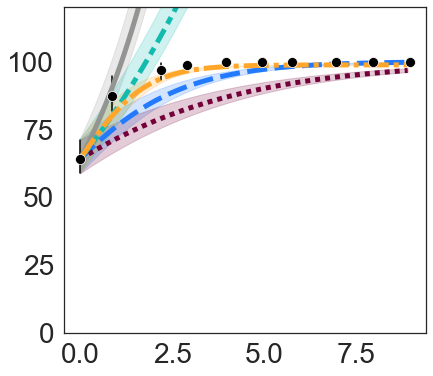

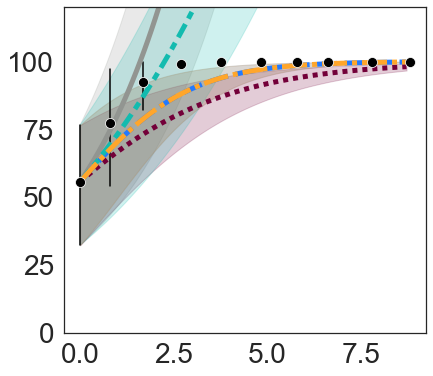

In [11]:
# Plot Predictions
for cellLine in ["OVCAR3","OVCAR4"]:
    outDir = os.path.join(modelDir,cellLine)
    testingData = dataDf_all[(dataDf_all.CellLine==cellLine) & (dataDf_all.SeedingDensity=="highDensity")]
    
    # Plot
    fig, ax = plt.subplots(1,1,figsize=(6.5,6))
    sns.lineplot(x="Time",y="TumourSize", hue="Model", style="Model", n_boot=2500,
             lw=5,palette=modelPalette,
             legend=False,
             data=modelPredictionDf[modelPredictionDf.CellLine==cellLine], ax=ax)
    sns.lineplot(x="Time",y="Confluence",style="CellLine",err_style='bars', #units="ReplicateId", estimator=None,
             markers="o", lw=0, markersize=10, color="black",
             legend=False,
            data=testingData,ax=ax)
    ax.set_ylim(0,120)
    ax.tick_params(labelsize=28)
    ax.set_xlabel("")
    ax.set_ylabel("")
    plt.savefig("./figures/predictions_growthModel_%s.pdf"%cellLine)

### Quantify goodness-of-fit of the predictions

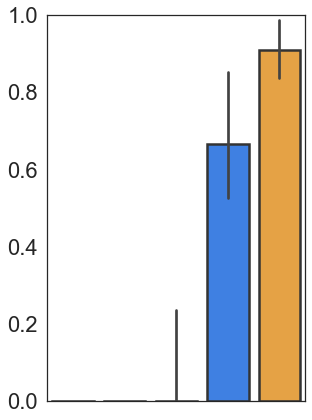

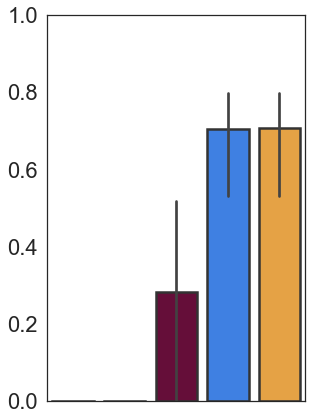

In [18]:
measure = "rSquared"

for cellLine in ["OVCAR3","OVCAR4"]:
    fig, ax = plt.subplots(1,1,figsize=(4.5,6))
    sns.barplot(x="Model",y=measure,
                edgecolor=".2",linewidth=2.5,
                palette=modelPalette,
                order=["Exponential", "vonBertalanffy", "Gompertz", "Logistic", "GeneralisedLogistic"],
                data=modelPredictionDf_comp[modelPredictionDf_comp.CellLine==cellLine], ax=ax)
    ax.set_ylim(0,1)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticks([])
    plt.tight_layout()
    plt.savefig("./figures/predictions_growth_hd_%s.pdf"%(cellLine))

## Summary table of fits and params 

In [13]:
# Assemble table
tmpList = []
for cellLine in ["OVCAR3","OVCAR4"]:
    outDir = os.path.join(modelDir,cellLine)

    # Compare AIC to that of other models
    tmpList2 = []
    for modelName in modelList:
        fitObj,_ = LoadFit(modelName,fitDir=os.path.join(outDir,modelName))
        tmpList2.append({"Model":modelName, "FitId":fitObj.fitId,
                        "r2":fitObj.rSq, "AIC":fitObj.aic, "BIC":fitObj.bic})
    comparisonDf_gof = pd.DataFrame(tmpList2)
    deltaAIC = min(comparisonDf_gof.AIC - comparisonDf_gof.AIC[comparisonDf_gof.Model=="GeneralisedLogistic"].values)

    # Gather information on generalised logistic model 
    fitObj,_ = LoadFit(modelName,fitDir=os.path.join(outDir,"GeneralisedLogistic"))
    tmpList.append({"CellLine":cellLine, "Model":modelName, "FitId":fitObj.fitId,
                    "DeltaAIC":deltaAIC,
                    **fitObj.params.valuesdict()})
comparisonDf_summary = pd.DataFrame(tmpList)


In [14]:
comparisonDf_summary

,CellLine,Model,FitId,DeltaAIC,DMax,r,K,v,N0
0,OVCAR3,GeneralisedLogistic,0,0.000000,100,0.468891,98.755814,2.603333,3.277335
1,OVCAR4,GeneralisedLogistic,0,-1.999759,100,0.730168,100.000000,1.001323,5.160717


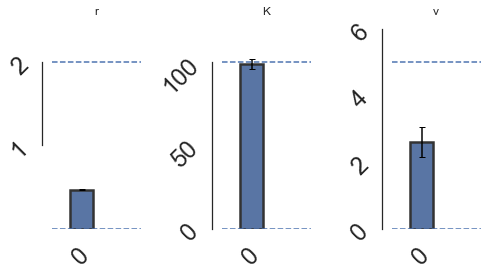

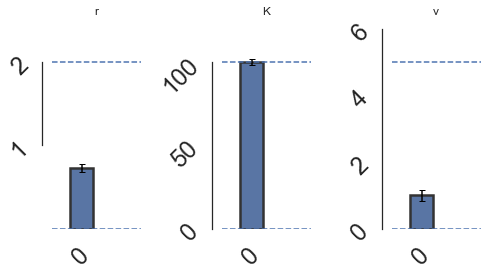

In [15]:
from fittingUtils import GenerateFitSummaryDf, PlotParameterDistribution_bars
modelName = "GeneralisedLogistic"
for cellLine in ["OVCAR3","OVCAR4"]:
    outDir = os.path.join(modelDir,cellLine)
    paramDf = GenerateFitSummaryDf(fitDir=os.path.join(outDir,modelName))
    PlotParameterDistribution_bars(paramDf, exampleFit=fitObj, x="FitId", nCols=3, figsize=(7,4))